# Two-level AMG+ for 1D Helmholtz / Repetitive
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [43]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [44]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int, num_components):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    
    #x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    #b = np.zeros_like(x_random)
    #x = hm.solve.run.run_iterative_method(
    #    level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    #start, end = 0, aggregate_size
    #x_aggregate_t = x[start:end].transpose()
    #print(x_aggregate_t.shape)
    #r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [45]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513012


## Level 0->1 Coarsening

In [46]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

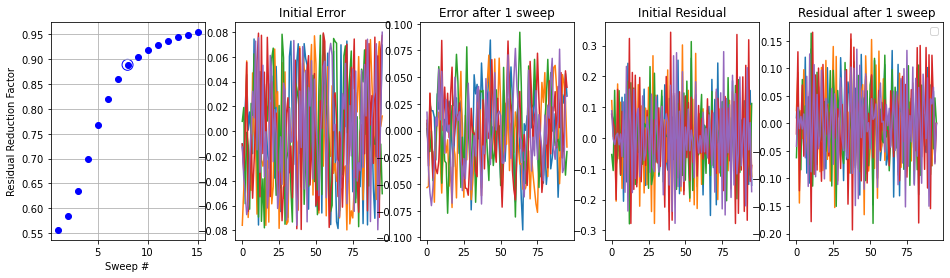

In [47]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [48]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.118


### Coarsening: Fixed (4/2)

In [49]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3
0,-0.29,-0.50,-0.60,-0.56
1,0.73,0.36,-0.12,-0.57


nu 100 s [1.    0.42  0.028 0.003] Energy error [0.388 0.026 0.003 0.   ]
INFO     Mock cycle conv [0.606 0.331 0.186 0.142 0.145 0.13  0.088 0.065 0.065 0.059 0.054]


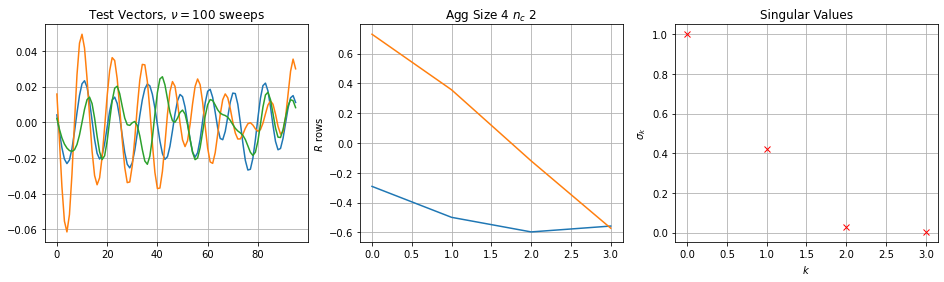

In [50]:
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.50,-0.56,-0.52,-0.41,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.62,-0.22,0.27,0.70,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.50,-0.56,-0.52,-0.41,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.62,-0.22,0.27,0.70,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,-0.56


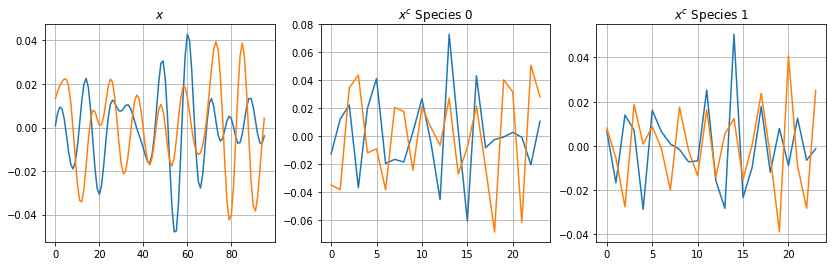

In [51]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [52]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.543 0.31  0.173 0.13  0.141 0.112 0.089 0.078]


### Interpolation $P = R^T$

In [53]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.83


### Interpolation by LS Fitting

In [54]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.54,0.31,0.17,0.13,0.14,0.11,0.09,0.08
P=R^T,nan,nan,nan,nan,nan,0.58,0.44,0.54,0.53,0.51,0.50,0.49,0.48
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.52,0.35,0.43,0.46,0.40,0.39,0.40,0.38
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.60,0.35,0.29,0.35,0.29,0.26,0.27,0.26
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.33,0.21,0.14,0.15,0.14,0.10,0.07
R A P caliber 2,1.00,2.00,192.00,1.20,0.02,0.51,0.40,0.47,0.49,0.43,0.42,0.43,0.41
R A P caliber 3,1.00,3.00,288.00,1.20,0.03,0.58,0.35,0.36,0.40,0.35,0.34,0.34,0.33
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.70,0.41,0.31,0.23,0.17,0.14,0.10,0.10


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [55]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.47,-0.61
1,-0.58,-0.22
2,-0.55,0.26
3,-0.38,0.70


A^1


,0,1,2,3,4,5
0,-0.18,-0.08,0.20,0.28,0.20,-0.40
1,-0.08,-1.44,-0.40,-0.55,0.28,-0.55


caliber 3 P


,0,1,2,3
0,-0.48,-0.55,0.00,-0.05
1,-0.57,-0.27,0.00,0.04
2,-0.53,0.34,0.04,0.00
3,-0.40,0.64,-0.05,0.00


A^1


,0,1,2,3,4,5,6,7
0,-0.12,-0.07,0.19,0.23,0.00,0.00,0.19,-0.33
1,-0.07,-1.20,-0.33,-0.43,0.00,0.00,0.23,-0.43


caliber 4 P


,0,1,2,3,4,5
0,-0.40,-0.40,0.00,0.00,-0.10,0.19
1,-0.63,-0.38,0.00,0.00,0.08,-0.14
2,-0.57,0.46,0.09,0.12,0.00,0.00
3,-0.35,0.48,-0.11,-0.15,0.00,0.00


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.08,-0.07,0.16,0.20,0.01,0.01,0.01,-0.02,0.16,-0.28
1,-0.07,-1.01,-0.28,-0.37,-0.02,-0.03,0.01,-0.03,0.20,-0.37


R*A*P
caliber 2 P


,0,1
0,-0.47,-0.61
1,-0.58,-0.22
2,-0.55,0.26
3,-0.38,0.70


A^1


,0,1,2,3,4,5
0,-0.20,-0.07,0.22,0.30,0.21,-0.42
1,-0.08,-1.46,-0.40,-0.55,0.28,-0.55


caliber 3 P


,0,1,2,3
0,-0.48,-0.55,0.00,-0.05
1,-0.57,-0.27,0.00,0.04
2,-0.53,0.34,0.04,0.00
3,-0.40,0.64,-0.05,0.00


A^1


,0,1,2,3,4,5
0,-0.15,-0.06,0.21,0.26,0.20,-0.38
1,-0.07,-1.29,-0.35,-0.48,0.24,-0.50


caliber 4 P


,0,1,2,3,4,5
0,-0.40,-0.40,0.00,0.00,-0.10,0.19
1,-0.63,-0.38,0.00,0.00,0.08,-0.14
2,-0.57,0.46,0.09,0.12,0.00,0.00
3,-0.35,0.48,-0.11,-0.15,0.00,0.00


A^1


,0,1,2,3,4,5
0,-0.03,-0.05,0.15,0.14,0.15,-0.19
1,-0.04,-0.63,-0.19,-0.16,0.15,-0.16


In [56]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.831e+01 RER 3.40889
INFO         1 |r| 4.184e+00 (0.22857) RER 0.06735 (0.01976) 62.126
INFO         2 |r| 1.089e+00 (0.26017) RER 0.01938 (0.28777) 56.168
INFO         3 |r| 2.224e-01 (0.20426) RER 0.00415 (0.21390) 53.636
INFO         4 |r| 7.198e-02 (0.32370) RER 0.00132 (0.31898) 54.430
INFO         5 |r| 1.763e-02 (0.24499) RER 0.00032 (0.24515) 54.396
INFO         6 |r| 5.237e-03 (0.29697) RER 0.00010 (0.29717) 54.359
INFO         7 |r| 1.501e-03 (0.28672) RER 0.00003 (0.28668) 54.367
INFO         8 |r| 4.038e-04 (0.26893) RER 0.00001 (0.26893) 54.367
INFO         9 |r| 1.271e-04 (0.31489) RER 0.00000 (0.31490) 54.366
INFO        10 |r| 3.611e-05 (0.28399) RER 0.00000 (0.28399) 54.366
INFO        11 |r| 1.120e-05 (0.31024) RER 0.00000 (0.31024) 54.366
INFO        12 |r| 3.511e-06 (0.31343) RER 0.00000 (0.31343) 54.366
INFO        13 |r| 1.071e-06 (0.30497) RER 0.00000 (0.30497) 54.366
INFO        14 |r| 3.370e-07 (0.31473) RER 0.00000 (0.31473) 54.366
INFO   

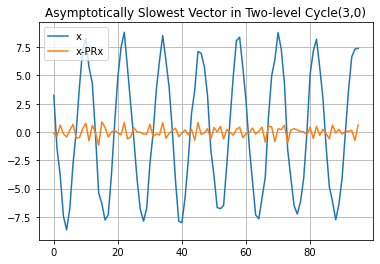

In [57]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].p.dot(m0[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [58]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [59]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [60]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a
#lam, v = eig(a.todense())
#np.real(lam)

#y = hm.analysis.ideal.null_space(a, tol=1e-5)
# plt.plot(y[:, 0])
# plt.plot(y[:, 1])
# plt.title("Null space vectors");

In [61]:
# Prepare initial guess that's orthogonal to the null space of A1.
x0 = hm.solve.run.random_test_matrix((a.shape[0], ), num_examples=5)
#x = x0 - y.dot(y.T.dot(x0))

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.407e-01                    4.456e-01    0.540
INFO     1     9.871e-02 (0.413) [0.413]    2.862e-01    0.347 (0.643)
INFO     2     4.771e-02 (0.483) [0.447]    2.299e-01    0.207 (0.602)
INFO     3     3.337e-02 (0.695) [0.519]    2.038e-01    0.166 (0.787)
INFO     4     2.543e-02 (0.763) [0.572]    1.863e-01    0.140 (0.838)
INFO     5     2.049e-02 (0.809) [0.612]    1.741e-01    0.123 (0.869)
INFO     6     1.728e-02 (0.847) [0.646]    1.651e-01    0.111 (0.898)
INFO     7     1.504e-02 (0.874) [0.674]    1.580e-01    0.102 (0.917)
INFO     8     1.336e-02 (0.892) [0.698]    1.522e-01    0.095 (0.930)
INFO     9     1.204e-02 (0.904) [0.718]    1.474e-01    0.089 (0.938)
INFO     10    1.097e-02 (0.913) [0.735]    1.432e-01    0.084 (0.944)
INFO     11    1.009e-02 (0.921) [0.750]    1.396e-01    0.079 (0.948)
INFO     12    9.344e-03 (0.926) [0.764]    1.365e-01    0.075 (0.951)
INFO 

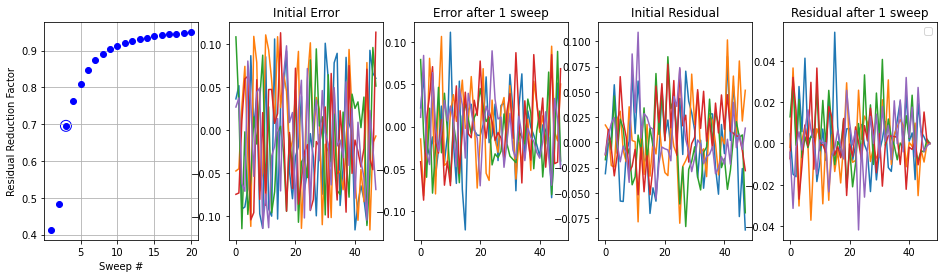

In [62]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20, x0=x0)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,0.58,-0.37,-0.25,0.68
1,-0.04,-0.62,0.78,-0.02


nu 100 s [1.    0.655 0.261 0.198] Energy error [0.591 0.264 0.16  0.   ]
INFO     Mock cycle conv [0.315 0.342 0.231 0.193 0.187 0.161 0.126 0.115 0.108 0.094 0.097]


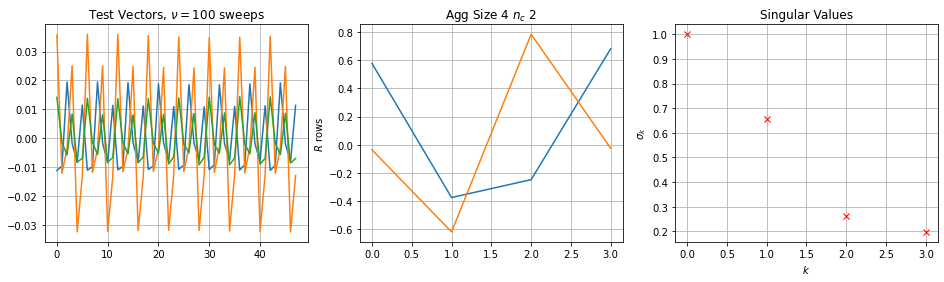

In [63]:
# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [64]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.15,-0.19,-0.03,-0.05,0.15,0.14
1,0.15,-0.16,-0.04,-0.63,-0.19,-0.16


In [65]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.002


In [66]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.15,-0.19,-0.03,-0.05,0.15,0.14
1,0.15,-0.16,-0.04,-0.63,-0.19,-0.16


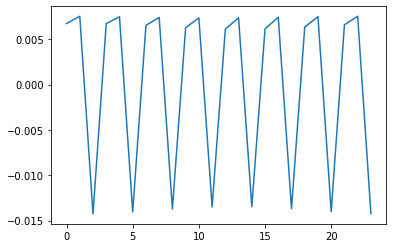

In [67]:
plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [68]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [69]:
 np.correlate(x[:, 0], x[:, 0], mode='full')

array([-0.   , -0.   ,  0.   , -0.   , -0.   ,  0.001, -0.001, -0.001,  0.001, -0.001, -0.001,  0.002, -0.001, -0.001,  0.002, -0.001, -0.001,  0.003, -0.002, -0.002,  0.003, -0.002, -0.001,  0.004, -0.002, -0.002,  0.004, -0.002, -0.002,  0.005, -0.002, -0.003,  0.004, -0.003, -0.002,  0.006, -0.003, -0.003,  0.005, -0.003, -0.003,  0.007, -0.003, -0.004,  0.006, -0.004, -0.003,  0.008, -0.003, -0.004,  0.006, -0.004, -0.003,  0.007, -0.003, -0.003,  0.005, -0.003, -0.003,  0.006, -0.002,
       -0.003,  0.004, -0.003, -0.002,  0.005, -0.002, -0.002,  0.004, -0.002, -0.002,  0.004, -0.001, -0.002,  0.003, -0.002, -0.002,  0.003, -0.001, -0.001,  0.002, -0.001, -0.001,  0.002, -0.001, -0.001,  0.001, -0.001, -0.001,  0.001, -0.   , -0.   ,  0.   , -0.   , -0.   ])

[1.    0.842 0.233 0.191]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,-0.69,0.15,0.50,-0.50,0.00,0.00,0.00,0.00,0.00,0.00
1,0.05,-0.74,0.60,0.31,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.69,0.15,0.50,-0.50,0.00,0.00
3,0.00,0.00,0.00,0.00,0.05,-0.74,0.60,0.31,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.69,0.15


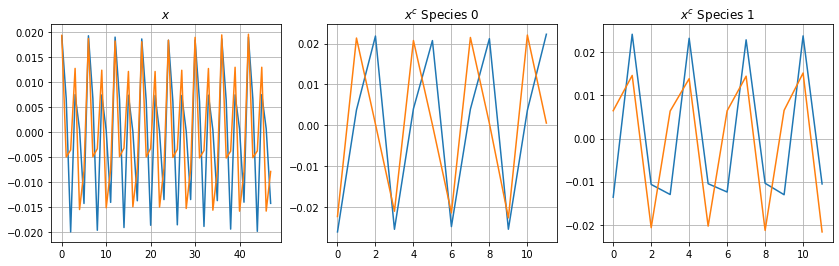

In [70]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

In [71]:
# a = level.a
# display(pd.DataFrame(a.todense()))

### Mock Cycle Rate

In [72]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.311 0.367 0.3   0.248 0.213 0.178 0.15  0.126 0.09  0.086 0.077]


In [73]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [74]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.52


### Interpolation by LS Fitting

In [75]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.31,0.37,0.30,0.25,0.21,0.18,0.15,0.13,0.09,0.09,0.08
P=R^T,nan,nan,nan,nan,nan,1.52,1.13,0.92,0.86,0.99,1.01,1.01,1.01,1.01,1.01,1.01
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,7.28,4.84,4.20,3.55,2.97,2.50,2.10,1.77,1.49,1.25,1.05
P^T A P caliber 3,0.00,3.00,144.00,1.17,0.00,0.49,0.20,0.04,0.06,0.06,0.05,0.04,0.04,0.04,0.04,0.04
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,1.12,0.19,0.07,0.08,0.05,0.04,0.02,0.02,0.02,0.02,0.01
R A P caliber 2,1.00,2.00,96.00,1.00,0.05,2.35,1.78,1.55,1.24,1.07,0.92,0.75,0.72,0.64,0.60,0.56
R A P caliber 3,1.00,3.00,144.00,1.00,0.04,0.88,0.53,0.49,0.40,0.34,0.28,0.22,0.19,0.17,0.17,0.18
R A P caliber 4,1.00,4.00,192.00,1.00,0.04,0.33,0.23,0.19,0.18,0.15,0.12,0.11,0.10,0.10,0.09,0.09


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 3.618e+00 RER 0.83419
INFO         1 |r| 4.647e-01 (0.12845) RER 0.07870 (0.09435) 5.905
INFO         2 |r| 7.885e-02 (0.16966) RER 0.01860 (0.23634) 4.239
INFO         3 |r| 1.542e-02 (0.19557) RER 0.00364 (0.19570) 4.236
INFO         4 |r| 2.860e-03 (0.18548) RER 0.00067 (0.18537) 4.239
INFO         5 |r| 4.213e-04 (0.14730) RER 0.00010 (0.14729) 4.239
INFO         6 |r| 8.566e-05 (0.20333) RER 0.00002 (0.20332) 4.239
INFO         7 |r| 1.877e-05 (0.21912) RER 0.00000 (0.21911) 4.239
INFO         8 |r| 3.369e-06 (0.17951) RER 0.00000 (0.17951) 4.239
INFO         9 |r| 4.377e-07 (0.12989) RER 0.00000 (0.12989) 4.239
INFO        10 |r| 9.598e-08 (0.21930) RER 0.00000 (0.21930) 4.239
INFO        11 |r| 2.134e-08 (0.22236) RER 0.00000 (0.22236) 4.239
INFO        12 |r| 3.289e-09 (0.15412) RER 0.00000 (0.15412) 4.239
INFO        13 |r| 5.229e-10 (0.15898) RER 0.00000 (0.15898) 4.239
INFO        14 |r| 1.027e-10 (0.19641) RER 0.00000 (0.19641) 4.239
INFO        15 |r| 2.

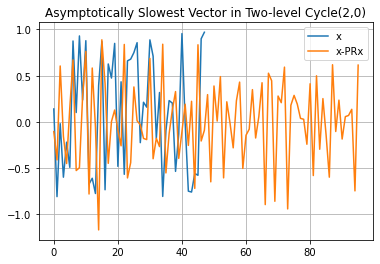

In [76]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[False][-1]  # P^T*A*P P high order
use_r_as_restriction = False

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [77]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]
1 lam [-0.    -0.    -0.004  0.005  0.005  0.029  0.029  0.047  0.047  0.059  0.066  0.066]


## 3-Level Method

In [82]:
m0[0].size, m0[1].size, m1[1].size

(96, 48, 24)

In [83]:
m0.add(m1[1])

In [84]:
m0

INFO         0 |r| 2.160e+01 RER 3.91408
INFO         1 |r| 2.381e+00 (0.11024) RER 0.03179 (0.00812) 74.883
INFO         2 |r| 4.724e-01 (0.19843) RER 0.00668 (0.21024) 70.676
INFO         3 |r| 7.861e-02 (0.16640) RER 0.00113 (0.16925) 69.487
INFO         4 |r| 1.566e-02 (0.19919) RER 0.00022 (0.19830) 69.798
INFO         5 |r| 3.070e-03 (0.19607) RER 0.00004 (0.19612) 69.780
INFO         6 |r| 6.857e-04 (0.22337) RER 0.00001 (0.22340) 69.769
INFO         7 |r| 1.524e-04 (0.22225) RER 0.00000 (0.22224) 69.770
INFO         8 |r| 3.484e-05 (0.22858) RER 0.00000 (0.22857) 69.771
INFO         9 |r| 7.950e-06 (0.22820) RER 0.00000 (0.22820) 69.771
INFO        10 |r| 1.853e-06 (0.23306) RER 0.00000 (0.23306) 69.771
INFO        11 |r| 4.360e-07 (0.23532) RER 0.00000 (0.23532) 69.771
INFO        12 |r| 1.024e-07 (0.23488) RER 0.00000 (0.23488) 69.771
INFO        13 |r| 2.418e-08 (0.23610) RER 0.00000 (0.23610) 69.771
INFO        14 |r| 5.666e-09 (0.23435) RER 0.00000 (0.23435) 69.771
INFO   

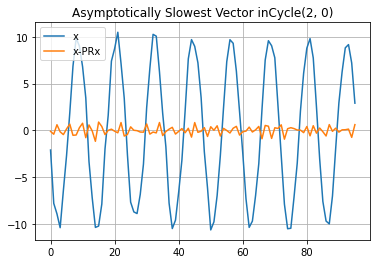

In [94]:
nu_pre = 2
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector inCycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();